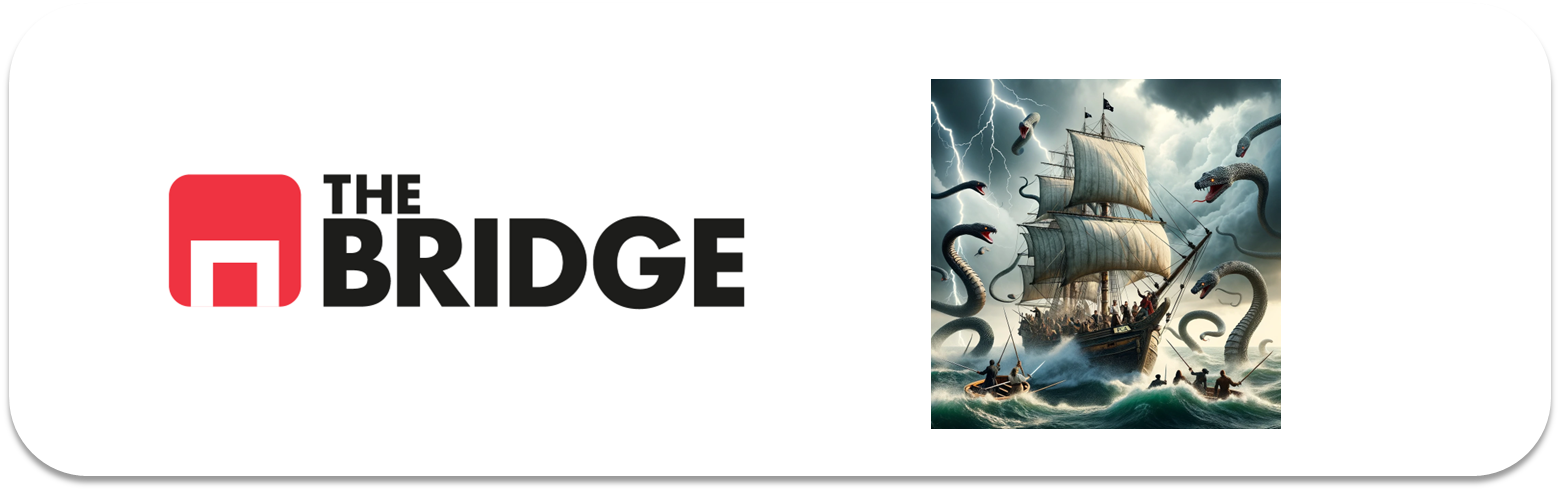

## PRACTICA OBLIGATORIA: **Seleccion Features**

* La práctica obligatoria de esta unidad consiste en hacer una comparativa de diferentes técnicas de selección de features sobre un dataset ya conocido. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Descripción General y Objetivo

El objetivo de la práctica es que juegues con las diferentes técncias de selección de features sobre un problema de clasificación. Para ello, tendrás que cargar el dataset de credit scoring que tienes en la carpeta "data" y que ya hemos trabajado anteriormente. A partir de ahí tendrás que probar diferentes técnicas de selección de features y compararlas todas entre sí y escoger finalmente el conjunto más sencillo con más potencia. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [78]:
# Common imports
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, SelectFromModel, RFE, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# to make this notebook's output stable across runs
np.random.seed(5)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Detalles e Instrucciones

El objetivo es que construyas un modelo final de clasificació sobre la variable "SeriousDlqin2yrs" del dataset que encontrarás en "data".  

Sigue los pasos del proceso de ML que hemos aprendido para problemas supervisados con el dataset que encontrarás en "data" pero con las siguiente salvedades:

1. Deshazte de las filas con nulos, para este ejercicio no nos importan. Convierte las features NumberOf... que creas conveniente a categóricas con 2 o 3 niveles a lo sumo.

2. A la hora de hacer el miniEda aplica los siguientes análisis y selección de features: 
    1. Análisis visual combinado con filtrado por valores de correlación y umbral de covarianza.
    2. Selección de features numéricas mediante SelectKBest y ANOVA, selecció de features categóricas mediante Mutual Information 
    3. Selección de las mejores features a través de un modelo intermedio (usando SelectFromModel)
    4. Selección de las mejores features empleando RFE.
    5. Selección de las mejores features empleando SFS.
    6. Selección de las mejores features mediante un sistema de hard-voting aplicado a lo obtenido en los pasos 1 a 5 anteriores.

    Para cada paso anterior (salvo el 1) se pide obtener una lista de features de "primera división" con un número de variables no superior a 6 (pueden ser menos).

3. Escoge tres modelos y a la hora compararlos para escoger el mejor, entrenalos con validación cruzada empleando las seis listas obtenidas anteriormente. Es decir tendrás 18 (6*3) medidas (emplea la métrica que creas más conveniente y si no se te ocurre ninguna el recall medio).  Escoge el mejor modelo y la mejor selección de features.

4. Optimiza los hiperparámetros del mejor modelo. Evalúalo contra test.


In [45]:
df = pd.read_csv('data/credit_npo.csv')
df.head(3)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0


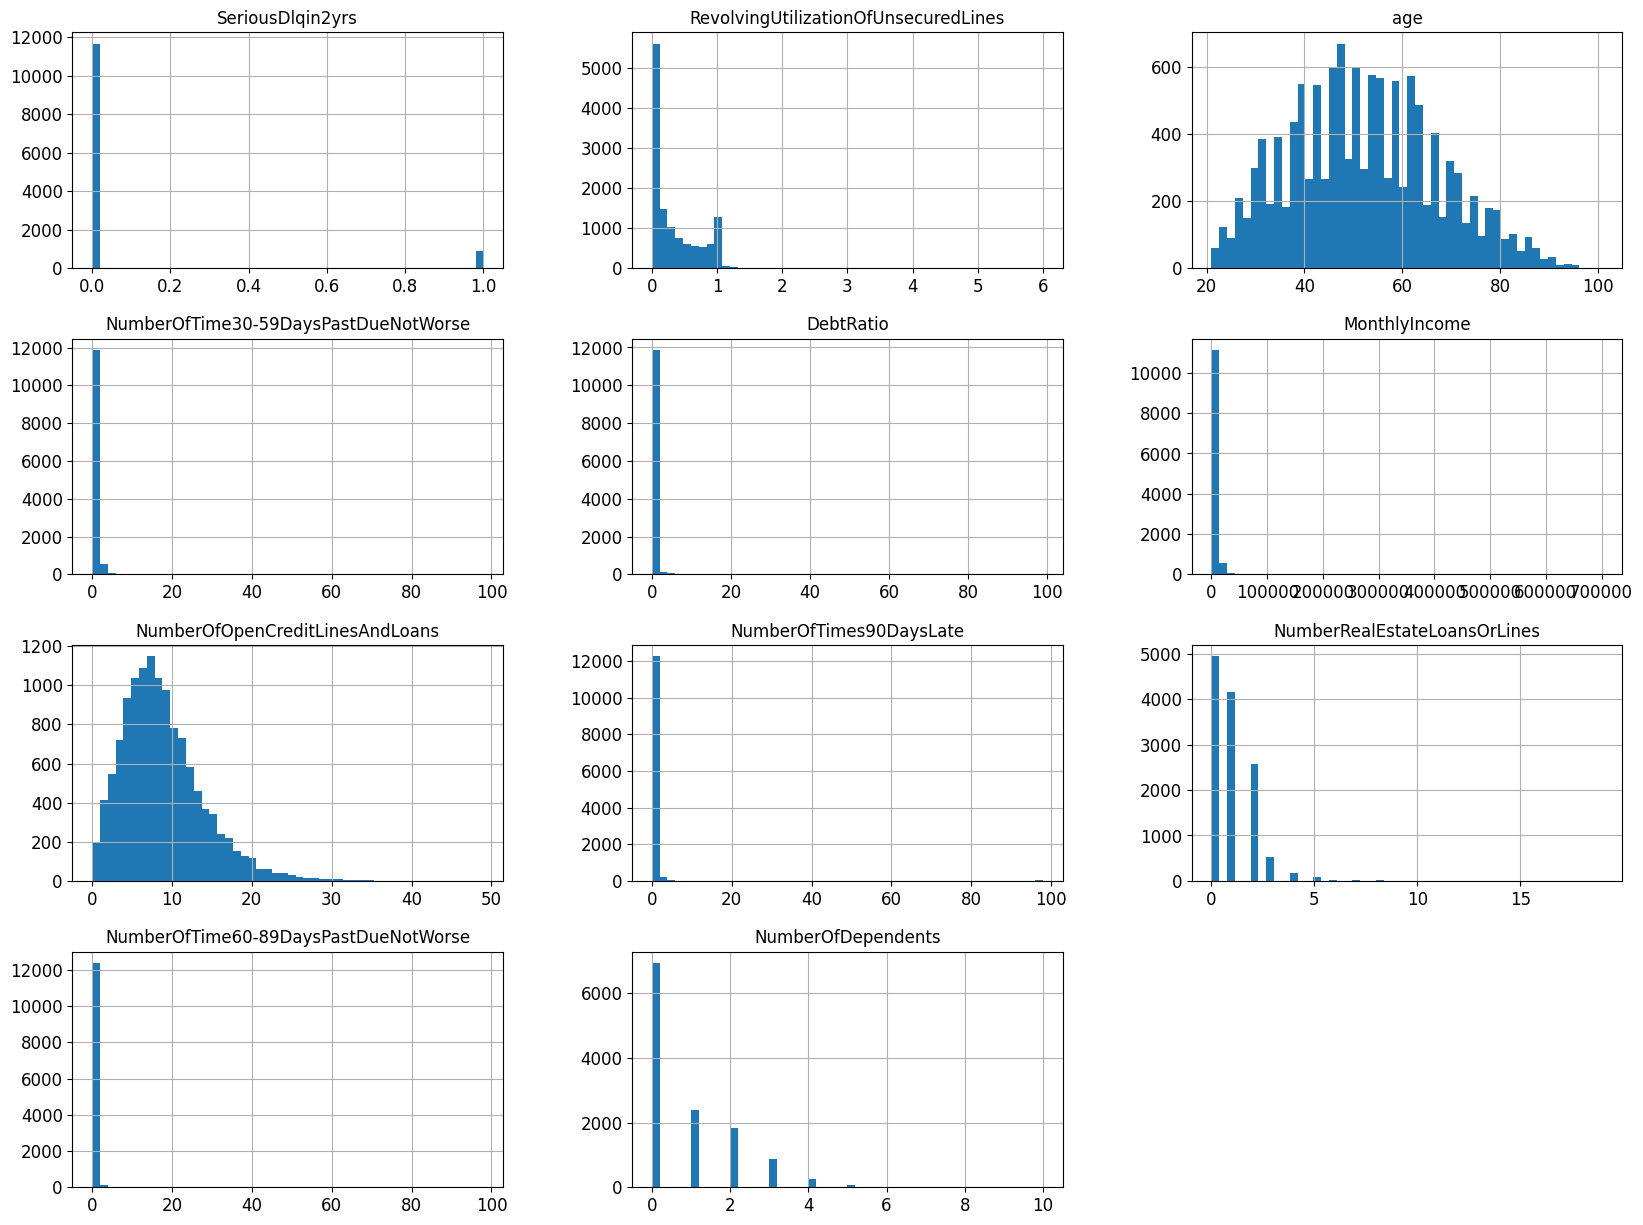

In [46]:
df.hist(bins=50, figsize=(20, 15))
plt.show()

In [47]:
def categorizar_por_distancia_directo(df, columnas):
    """
    Categoriza las columnas numéricas de un DataFrame en 'Bajo', 'Medio', 'Alto' directamente en el DataFrame original.
    
    Parámetros:
    - df: DataFrame de pandas.
    - columnas: Lista de columnas numéricas a categorizar.
    """
    for col in columnas:
        min_val = df[col].min()
        max_val = df[col].max()

        # Calcular los percentiles de distancia
        dist_15 = min_val + (max_val - min_val) * 0.15
        dist_45 = min_val + (max_val - min_val) * 0.45

        # Categorizar usando pd.cut() directamente en el DataFrame
        df[f'{col}_cat'] = pd.cut(df[col], 
                                  bins=[min_val, dist_15, dist_45, max_val], 
                                  labels=[1, 2, 3],
                                  include_lowest=True)

In [48]:
df = df.dropna()

col_to_cat = df.columns.difference(['SeriousDlqin2yrs', 'age', 'RevolvingUtilizationOfUnsecuredLines',  'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines', 'NumberOfDependents']).tolist()
categorizar_por_distancia_directo(df, col_to_cat)
df.drop(columns= col_to_cat)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,DebtRatio_cat,MonthlyIncome_cat,NumberOfTime30-59DaysPastDueNotWorse_cat,NumberOfTime60-89DaysPastDueNotWorse_cat,NumberOfTimes90DaysLate_cat
0,0,0.081892,37,12,0,0.0,1,1,1,1,1
1,0,0.023413,74,9,1,0.0,1,1,1,1,1
2,0,0.000000,43,2,0,2.0,1,1,1,1,1
3,0,0.492754,44,4,2,3.0,1,1,1,1,1
4,0,1.000000,63,3,0,1.0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
12532,0,0.197116,59,6,1,0.0,1,1,1,1,1
12533,0,0.036726,62,12,1,0.0,1,1,1,1,1
12534,0,0.120313,49,7,2,2.0,1,1,1,1,1
12535,0,0.252566,63,9,0,1.0,1,1,1,1,1


In [49]:
# 2.A

In [50]:
# 2.B
columnas = df.columns.tolist()

# Y seleccionaremos las características numéricas excluyendo la variable objetivo para el análisis ANOVA
X = df.drop(columnas[0], axis=1)  # Todas las características menos la variable objetivo
y = df[columnas[0]]              # La variable objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicando SelectKBest con ANOVA para seleccionar las 6 mejores características numéricas
select_k_best_anova = SelectKBest(f_classif, k=6)
X_new_anova = select_k_best_anova.fit_transform(X_train, y_train)

# Obteniendo las características seleccionadas
features_anova_selected = X.columns[select_k_best_anova.get_support()].tolist()

features_anova_selected

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfTimes90DaysLate_cat']

In [51]:
# 2.C
# Crear el modelo Random Forest para usar en SelectFromModel
rf = RandomForestClassifier(n_estimators=100)

# Usar SelectFromModel con Random Forest como base
sfm = SelectFromModel(rf, max_features=6)
sfm.fit(X_train, y_train)

# Obteniendo las características seleccionadas
features_selected_from_model = X_train.columns[sfm.get_support()].tolist()

features_selected_from_model

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate']

In [69]:
# 2.D 
# Configurar el modelo de regresión logística con un número mayor de iteraciones
log_reg = LogisticRegression(max_iter=1000)

# Crear un pipeline que incluya el escalado de datos y la regresión logística
pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('log_reg', log_reg)])

# Aplicar RFE con el pipeline como estimador
selector = RFE(pipeline, n_features_to_select=5, step=1, importance_getter='named_steps.log_reg.coef_')

# Ajustar el modelo
selector = selector.fit(X_train, y_train)

# Obtener los índices de las características seleccionadas
selected_features_RFE = X_train.columns[selector.support_].tolist()

# Imprimir las características seleccionadas
print("Selected features:")
print("\n".join([f"{x}" for x in selected_features_RFE]))

Selected features:
NumberOfTimes90DaysLate
NumberOfTime60-89DaysPastDueNotWorse
NumberOfTime30-59DaysPastDueNotWorse_cat
NumberOfTime60-89DaysPastDueNotWorse_cat
NumberOfTimes90DaysLate_cat


In [75]:
# 2.E

# Definir el selector de características secuenciales
sfs = SequentialFeatureSelector(pipeline, n_features_to_select=6, direction='forward')

# Ajustar el SFS al conjunto de entrenamiento
sfs.fit(X_train, y_train)

# Transformar los conjuntos de datos para seleccionar las características
X_train_selected = sfs.transform(X_train)
X_test_selected = sfs.transform(X_test)

# Obtener los índices de las características seleccionadas
selected_features_SFS = X_train.columns[sfs.get_support()].tolist()
print("Selected features:")
print("\n".join([f"{x}" for x in selected_features_RFE]))

Selected features:
NumberOfTimes90DaysLate
NumberOfTime60-89DaysPastDueNotWorse
NumberOfTime30-59DaysPastDueNotWorse_cat
NumberOfTime60-89DaysPastDueNotWorse_cat
NumberOfTimes90DaysLate_cat


In [77]:
# 2. F 
from collections import Counter

# Combina todas las listas en una sola lista
all_features = features_anova_selected + features_selected_from_model + selected_features_RFE + selected_features_SFS

# Cuenta la frecuencia de cada característica
feature_counts = Counter(all_features)

# Selecciona las 5 características más frecuentes
top_5_features = [feature for feature, count in feature_counts.most_common(5)]

print("Top 5 voted features:", top_5_features)

Top 5 voted features: ['NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTimes90DaysLate_cat']


In [79]:
# Definir los modelos a comparar
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Definir las listas de características seleccionadas previamente
feature_lists = [top_5_features, selected_features_RFE, selected_features_SFS, features_selected_from_model, features_anova_selected]

# Inicializar un diccionario para almacenar los resultados
results = {}

# Iterar sobre cada modelo
for model_name, model in models.items():
    model_results = []
    # Iterar sobre cada lista de características
    for features in feature_lists:
        # Crear un pipeline con escalado de datos y el modelo
        pipeline = make_pipeline(StandardScaler(), model)
        # Calcular el recall medio utilizando validación cruzada
        recall = cross_val_score(pipeline, X_train[features], y_train, cv=5, scoring='recall').mean()
        model_results.append(recall)
    # Almacenar los resultados para el modelo actual
    results[model_name] = model_results

# Imprimir los resultados
for model_name, recalls in results.items():
    print(f"{model_name}: {recalls}")

Logistic Regression: [0.14935064935064934, 0.15390749601275916, 0.1448621553884712, 0.03922305764411027, 0.16298701298701299]
Decision Tree: [0.269958988380041, 0.14344953292321713, 0.22627022100706312, 0.27607655502392336, 0.2669856459330143]
Random Forest: [0.22024379129642288, 0.16754385964912283, 0.23842560947824104, 0.19921394395078607, 0.20064935064935066]


In [ ]:
# De los que me han salido el mejor modelo es el Decisión Tree para SelectFromModel

### EXTRA

Aplica la PCA como método de selección, escoge un número de componentes en función de la varianza explicada y crea un dataset con el que entrenar el mismo tipo de modelo ganador de la parte general. Entrenalo y evalúalo contra test, comenta el resultado.